# **Notebook 2b**: Mounting Type

<span style="font-size: 1.5rem;">By **Michael Farrugia**</span>

The chosen object detection model for this task is RF-DETR. This notebook is therefore similarly structured to Notebook 2a, with the main difference used and the model prediction task.

## **Environment Setup**

In [1]:
INSTALL_PACKAGES = False

In [2]:
if INSTALL_PACKAGES:
    !pip install -r requirements.txt

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Dataset Validation**

The images used in this notebook are split according to the `.json` files. To use the images in training, the `images` folder must exist - if this folder does not exist, the cell below is used to create the necessary folders according to how the dataset is split.

In [4]:
import json

with open("./dataset/COCO-based_COCO_mounting/annotations/train.json", "r") as f:
    train_annotations = json.load(f)

with open("./dataset/COCO-based_COCO_mounting/annotations/val.json", "r") as f:
    val_annotations = json.load(f)

with open("./dataset/COCO-based_COCO_mounting/annotations/test.json", "r") as f:
    test_annotations = json.load(f)

print(f"Number of images in the train set: {len(train_annotations ['images'])}")
print(f"Number of images in the validation set: {len(val_annotations ['images'])}")
print(f"Number of images in the test set: {len(test_annotations ['images'])}")

Number of images in the train set: 483
Number of images in the validation set: 88
Number of images in the test set: 86


In [5]:
import os
import shutil

if not os.path.exists("./dataset/COCO-based_COCO_mounting/images/"):
    os.makedirs("./dataset/COCO-based_COCO_mounting/images/")

    for dataset, dataset_type in zip([train_annotations, val_annotations, test_annotations], ["train", "val", "test"]):
        os.makedirs(f"./dataset/COCO-based_COCO_mounting/images/{dataset_type}/")
        img_filenames = [img ["file_name"] for img in dataset ["images"]]
        
        for img_filename in img_filenames:
            member_name = img_filename.split("-") [1].split("_") [0]

            img_src_path = f"./{member_name}/images/{img_filename}"
            img_dst_path = f"./dataset/COCO-based_COCO_mounting/images/{dataset_type}/{img_filename}"
            
            shutil.copyfile(img_src_path, img_dst_path)

Furthermore, RF-DETR expects a `_annotations.coco.json` file to exist in each of the `train`, `val` and `test` folders. The cell below creates these files by splitting the original annotations file according to the image splits. Other requirements for RF-DETR compatibility, such as 0-indexed category ids and the presence of the `supercategory` field, are also handled in the cell below.

Finally, rather than using `val`, RF-DETR uses `valid`. The `val` folder is simply copied into the `valid` folder.

In [6]:
fixed_train_annotations = train_annotations.copy()
fixed_val_annotations = val_annotations.copy()
fixed_test_annotations = test_annotations.copy()

for dataset in [fixed_train_annotations, fixed_val_annotations, fixed_test_annotations]:
    min_category_id = min(category ["id"] for category in dataset ["categories"])
    
    if "supercategory" not in dataset ["categories"] [0]:
        for category in dataset ["categories"]:
            category ["supercategory"] = "Maltese Traffic Sign"
            
            if min_category_id == 1:
                category ["id"] -= 1

    if min_category_id == 1:
        for annotation in dataset ["annotations"]:
            annotation ["category_id"] -= 1

In [7]:
# check if _annotations.coco.json files exist in train, val, test folders
for dataset_type in ["train", "val", "test"]:
    annotation_file_path = f"./dataset/COCO-based_COCO_mounting/images/{dataset_type}/_annotations.coco.json"
    
    if not os.path.exists(annotation_file_path):
        print(f"_annotations.coco.json file not found in {dataset_type} folder. Creating the file...")
        if dataset_type == "train":
            with open(annotation_file_path, "w") as f:
                json.dump(fixed_train_annotations, f)
        elif dataset_type == "val":
            with open(annotation_file_path, "w") as f:
                json.dump(fixed_val_annotations, f)
        else: 
            with open(annotation_file_path, "w") as f:
                json.dump(fixed_test_annotations, f)
    else:
        print(f"_annotations.coco.json file already exists in {dataset_type} folder")

_annotations.coco.json file not found in train folder. Creating the file...
_annotations.coco.json file not found in val folder. Creating the file...
_annotations.coco.json file not found in test folder. Creating the file...


In [8]:
# copy val folder to valid folder
if not os.path.exists("./dataset/COCO-based_COCO_mounting/images/valid/"):
    shutil.copytree("./dataset/COCO-based_COCO_mounting/images/val/", "./dataset/COCO-based_COCO_mounting/images/valid/")
    print("Copied val folder to valid folder")

Copied val folder to valid folder


## **Model Setup and Configuration**

In [9]:
from rfdetr import RFDETRBase

rf_detr_model = RFDETRBase()

Loading pretrain weights


## **Model Training**

In [ ]:
rf_detr_model.train(
    dataset_dir = "./dataset/COCO-based_COCO_mounting/images/", 
    tensorboard = True, 
    device = device, 
    num_epochs = 10,
    early_stopping = True,
    early_stopping_patience = 3,
    resolution = 448, # required to be a 56-divisible number
    batch_size = 4,
    output_dir = "work_dirs/rf-detr-mounting-type",
    lr = 1e-4,
    grad_accum_steps = 4,
)

## **Model Evaluation**

In [11]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path = "./dataset/COCO-based_COCO_mounting/images/test/",
    annotations_path = "./dataset/COCO-based_COCO_mounting/images/test/_annotations.coco.json",
)

In [12]:
rf_detr_model.optimize_for_inference()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [13]:
from tqdm import tqdm
from PIL import Image

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = rf_detr_model.predict(image)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 86/86 [00:26<00:00,  3.26it/s]


In [14]:
map_metric = sv.metrics.MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.635
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.672
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.672
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.635


### **Confidence Histogram**

Saved confidence histogram to: work_dirs/rf-detr-mounting-type\confidence_histogram.png


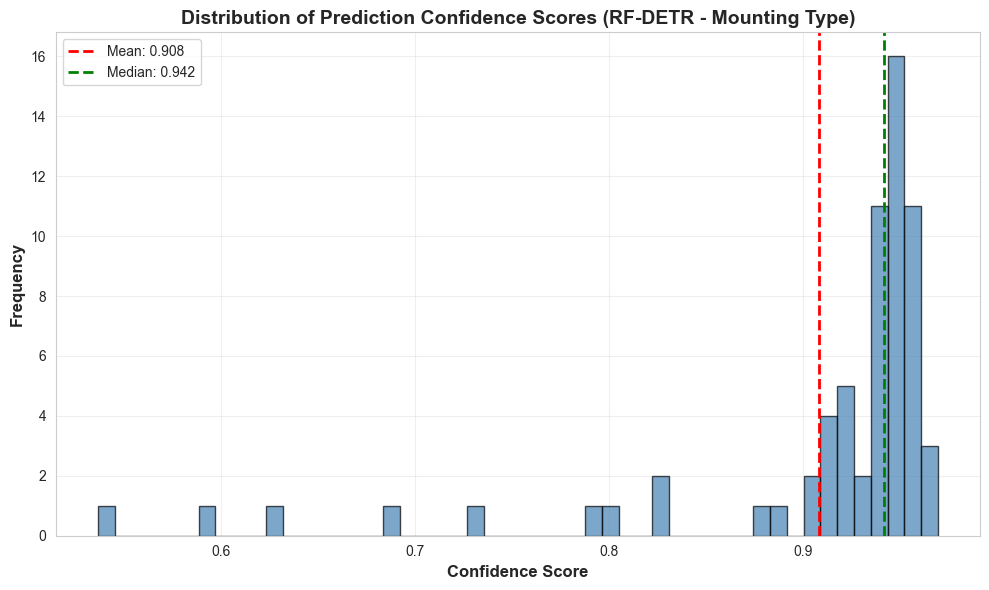

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect all confidence scores from predictions
all_confidences = []
for pred in predictions:
    all_confidences.extend(pred.confidence.tolist())

# Create histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(all_confidences, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Prediction Confidence Scores (RF-DETR - Mounting Type)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add statistics
mean_conf = np.mean(all_confidences)
median_conf = np.median(all_confidences)
ax.axvline(mean_conf, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf:.3f}')
ax.axvline(median_conf, color='green', linestyle='--', linewidth=2, label=f'Median: {median_conf:.3f}')
ax.legend()

plt.tight_layout()
output_path = os.path.join("work_dirs/rf-detr-mounting-type", "confidence_histogram.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved confidence histogram to: {output_path}")
plt.show()

## **Visualizations**

Saved qualitative results to: work_dirs/rf-detr-mounting-type\qualitative_results.png


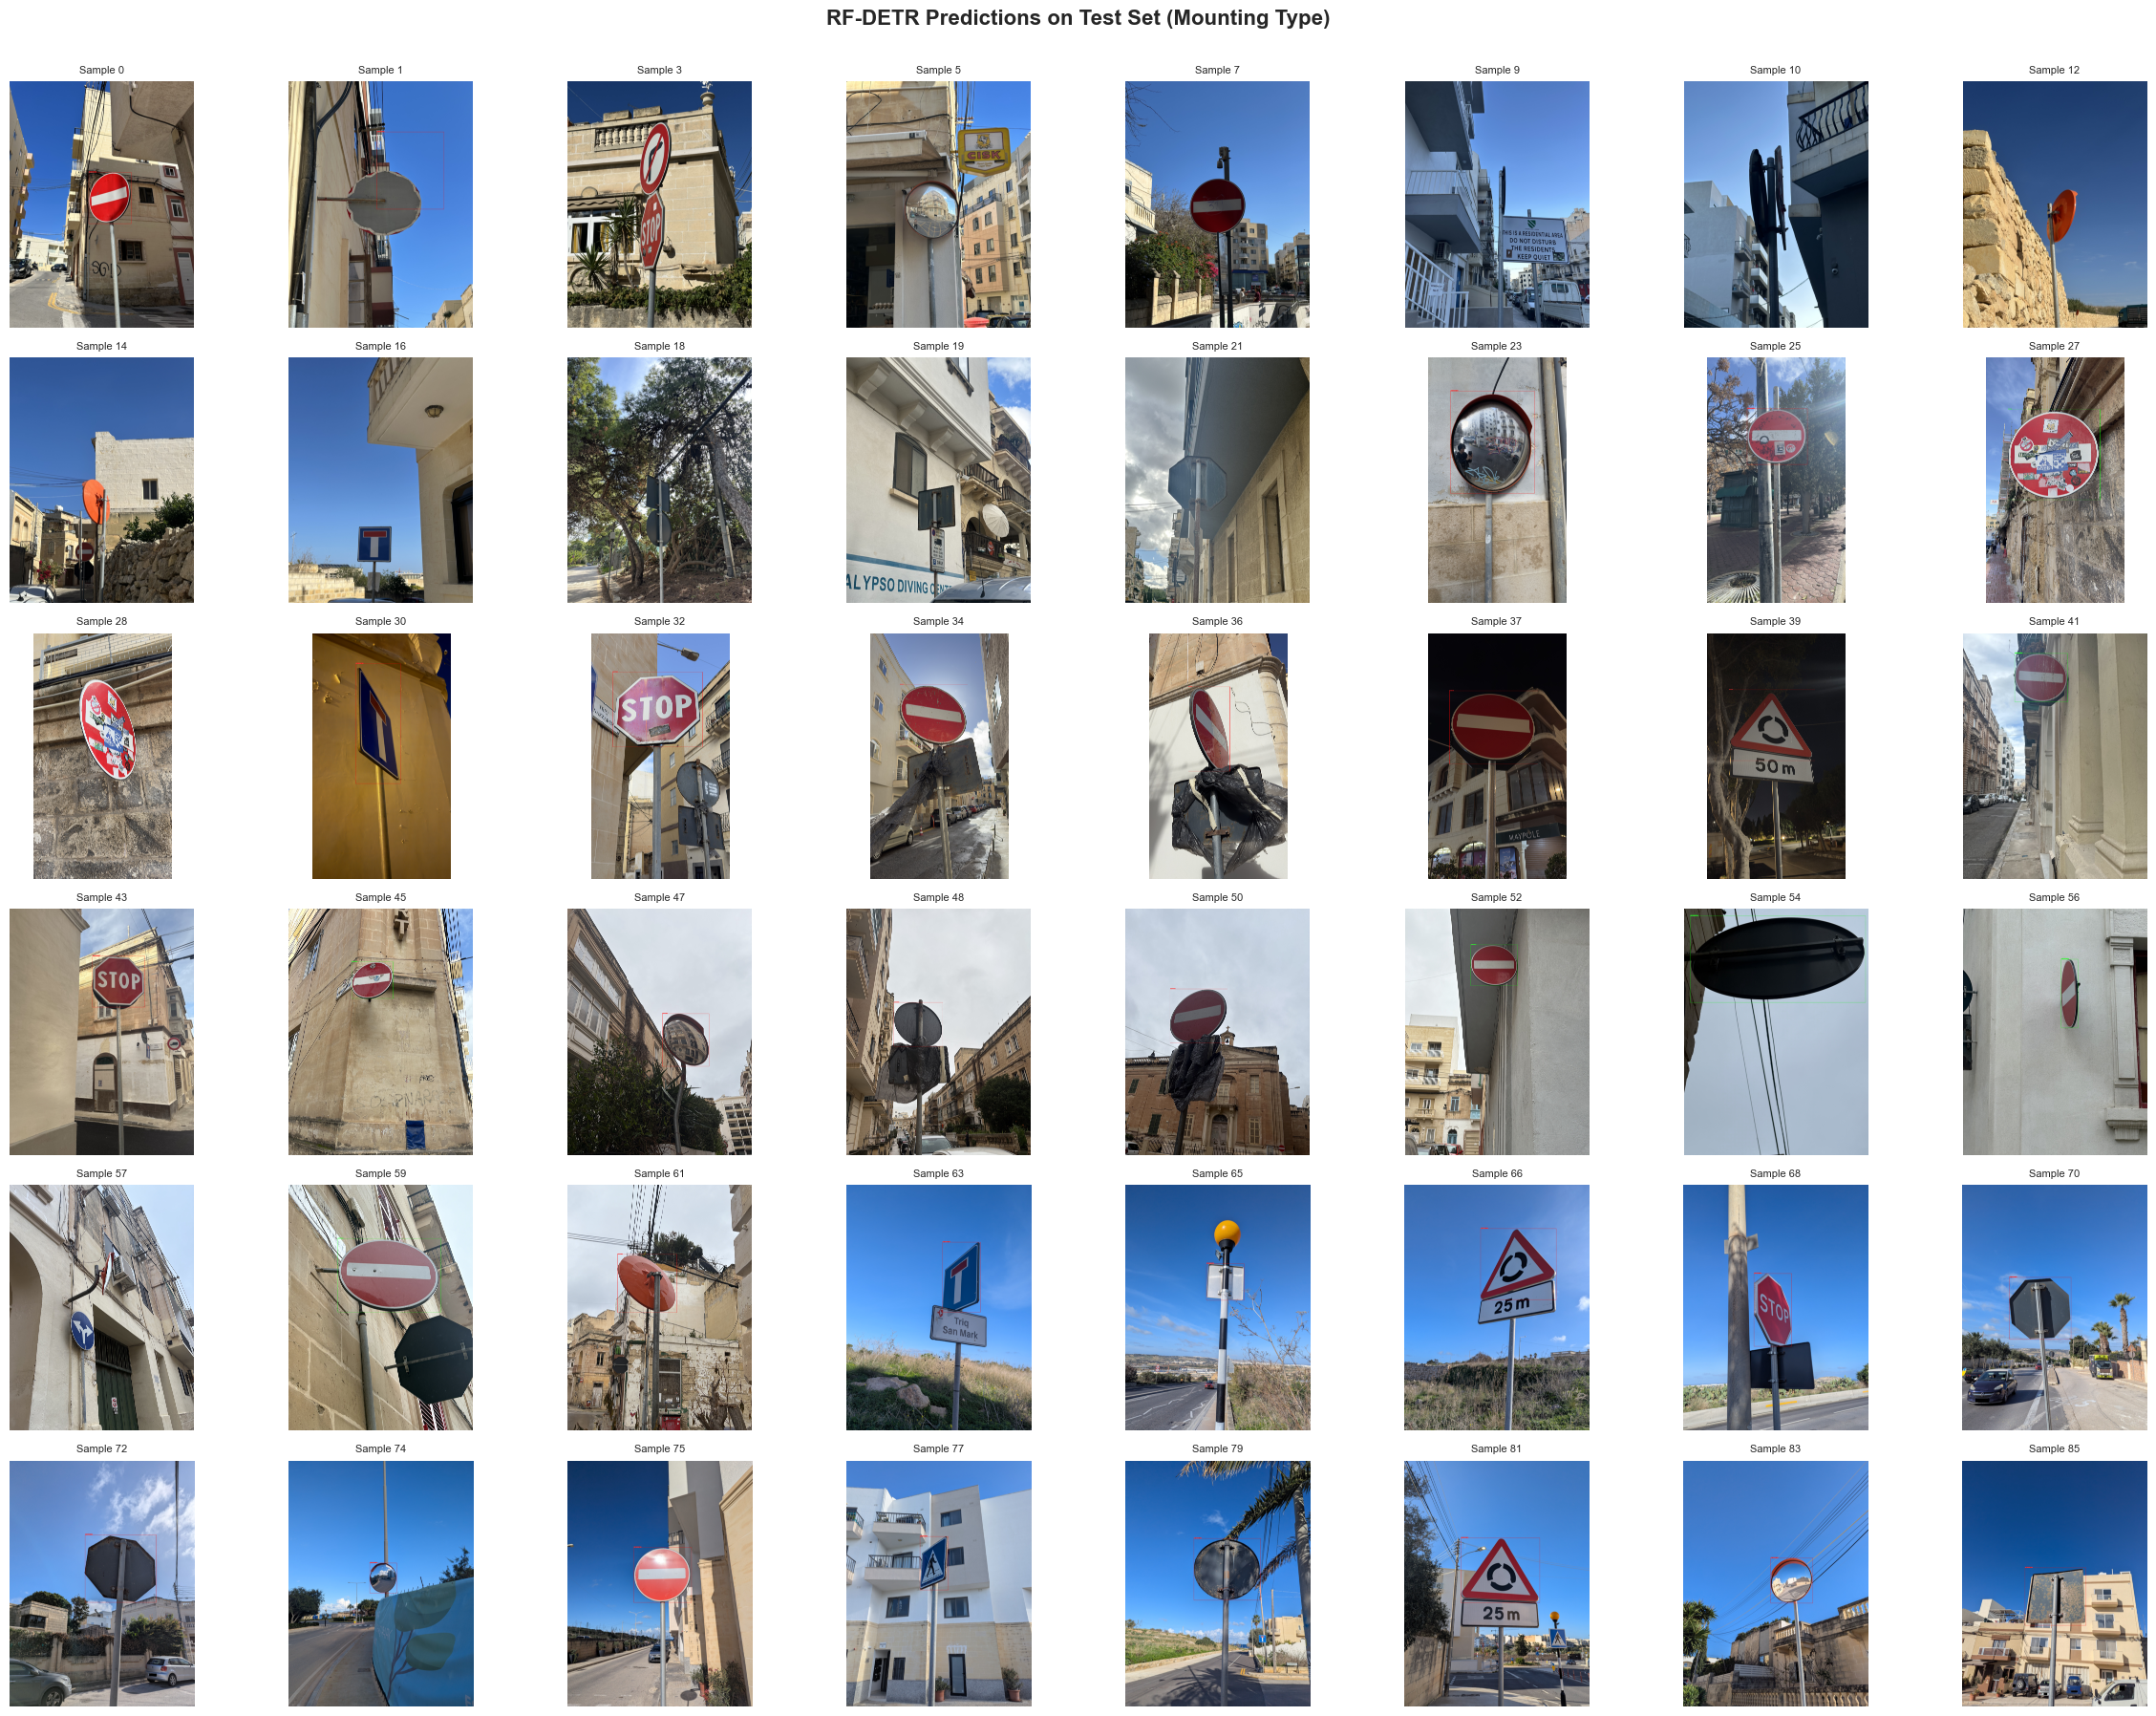

In [30]:
import cv2

# Color mapping for mounting types
COLORS = {
    0: (255, 0, 0),      # Wall-Mounted - Blue
    1: (0, 255, 0),      # Pole-Mounted - Green  
    2: (0, 0, 255),      # Overhead-Mounted - Red
    3: (255, 255, 0)     # Standalone - Cyan
}

# Select 48 representative test images (6x8 grid)
num_samples = 48
sample_indices = np.linspace(0, len(ds) - 1, num_samples, dtype=int)

# Create figure
fig, axes = plt.subplots(6, 8, figsize=(24, 18))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    path, image, annotations = ds[sample_idx]
    
    # Load image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get predictions
    pil_img = Image.open(path)
    detections = rf_detr_model.predict(pil_img)
    
    # Draw predictions on image
    for bbox, class_id, conf in zip(detections.xyxy, detections.class_id, detections.confidence):
        x1, y1, x2, y2 = bbox.astype(int)
        color = COLORS.get(class_id, (128, 128, 128))
        
        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Add label
        label = f"{CLASS_NAMES[class_id]}: {conf:.2f}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        cv2.rectangle(img, (x1, y1 - h - 4), (x1 + w, y1), color, -1)
        cv2.putText(img, label, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Sample {sample_idx}", fontsize=8)

plt.suptitle('RF-DETR Predictions on Test Set (Mounting Type)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])

output_path = os.path.join("work_dirs/rf-detr-mounting-type", "qualitative_results.png")
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Saved qualitative results to: {output_path}")
plt.show()

## **Inference Speed Measurement**

In [33]:
import time
import numpy as np

# Device info for export
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
batch_size_inference = 1  # RF-DETR processes images one at a time

# Prepare test images for speed measurement
test_image_paths = [os.path.join("./dataset/COCO-based_COCO_mounting/images/test/", img['file_name']) 
                    for img in fixed_test_annotations['images'][:100]]  # Use first 100 images

# Warmup
print("Warming up...")
warmup_iterations = 10
for i in range(warmup_iterations):
    test_img = Image.open(test_image_paths[i % len(test_image_paths)])
    _ = rf_detr_model.predict(test_img)

# Timed inference
print("Measuring inference speed...")
timed_iterations = 100
latencies = []

for i in range(timed_iterations):
    test_img = Image.open(test_image_paths[i % len(test_image_paths)])
    
    # Time inference with GPU sync
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    start_time = time.time()
    
    _ = rf_detr_model.predict(test_img)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()
    
    latencies.append((end_time - start_time) * 1000)  # Convert to ms

# Compute statistics
mean_latency = np.mean(latencies)
std_latency = np.std(latencies)
fps = 1000.0 / mean_latency

print(f"\nInference Speed on {device_name}:")
print(f"Mean Latency: {mean_latency:.2f} ± {std_latency:.2f} ms")
print(f"FPS: {fps:.2f}")
print(f"Iterations: {timed_iterations} (after {warmup_iterations} warmup)")

Warming up...
Measuring inference speed...

Inference Speed on NVIDIA GeForce RTX 4070:
Mean Latency: 173.21 ± 70.08 ms
FPS: 5.77
Iterations: 100 (after 10 warmup)


In [39]:
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.635
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.672
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.672
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.635


## **Per-Class Metrics**

In [ ]:
print("RESULTS EXPORT FOR COMPARISON")
print()

# Configuration constants
NUM_EPOCHS = 10
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
IMAGE_SIZE = 448
OUTPUT_DIR = "work_dirs/rf-detr-mounting-type"

# Get checkpoint file size (if exists)
import glob
checkpoint_files = glob.glob(f"{OUTPUT_DIR}/*.pt") + glob.glob(f"{OUTPUT_DIR}/*.pth")
if checkpoint_files:
    checkpoint_size_mb = os.path.getsize(checkpoint_files[0]) / (1024 * 1024)
else:
    checkpoint_size_mb = 0.0

# Compile results
results_export = {
    "student": "MichaelFarrugia",
    "model_name": "rf_detr",
    "task": "mounting_type",
    "framework": "RF-DETR (PyTorch)",
    "framework_version": torch.__version__,
    
    "dataset": {
        "name": "MTSD Mounting Type",
        "num_classes": len(CLASS_NAMES),
        "class_names": CLASS_NAMES,
        "train_images": len(train_annotations['images']),
        "val_images": len(val_annotations['images']),
        "test_images": len(test_annotations['images'])
    },
    
    "training": {
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "image_size": f"{IMAGE_SIZE}x{IMAGE_SIZE}",
        "augmentation": "RF-DETR default augmentations",
        "pretrained": "COCO",
        "seed": None,
        "total_time_hours": None,
        "optimizer": "AdamW",
        "lr_scheduler": "Cosine",
        "early_stopping": True,
        "early_stopping_patience": 3
    },
    
    "metrics": {
        "mAP": 0.635,
        "mAP50": 0.672,
        "mAP75": 0.672,
        "per_class_AP": {name: round(ap, 4) for name, ap in per_class_ap.items()}
    },
    
    "model_complexity": {
        "num_parameters": num_params,
        "checkpoint_size_mb": round(checkpoint_size_mb, 2)
    },
    
    "speed": {
        "device": device_name,
        "batch_size": batch_size_inference,
        "num_warmup": warmup_iterations,
        "num_samples": timed_iterations,
        "mean_latency_ms": round(mean_latency, 2),
        "std_latency_ms": round(std_latency, 2),
        "FPS": round(fps, 2),
        "includes_preprocessing": True
    },
    
    "artifacts": {
        "work_dir": OUTPUT_DIR,
        "checkpoint_best": f"{OUTPUT_DIR}/best.pt",
        "tensorboard_logdir": f"{OUTPUT_DIR}/tensorboard",
        
        "plots": {
            "training_curves": "params/rf-detr-mounting-type/metrics_plot.png",
            "per_class_ap_chart": os.path.join(OUTPUT_DIR, "per_class_ap.png"),
            "qualitative_grid": os.path.join(OUTPUT_DIR, "qualitative_results.png"),
            "confidence_histogram": os.path.join(OUTPUT_DIR, "confidence_histogram.png")
        }
    }
}

# Save results
os.makedirs(OUTPUT_DIR, exist_ok=True)
export_path = os.path.join(OUTPUT_DIR, 'results_export.json')
with open(export_path, 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"Results exported to: {export_path}")
print()

# Display summary
print("EXPORT SUMMARY")
print(f"Student: {results_export['student']}")
print(f"Model: {results_export['model_name']}")
print(f"Task: {results_export['task']}")
print(f"Test mAP@0.5:0.95: {results_export['metrics']['mAP']:.4f}")
print(f"Test mAP@0.5: {results_export['metrics']['mAP50']:.4f}")
print(f"Parameters: {results_export['model_complexity']['num_parameters']:,}")
print(f"Speed: {results_export['speed']['FPS']:.2f} FPS")
print()

RESULTS EXPORT FOR COMPARISON



TypeError: 'MeanAveragePrecision' object is not subscriptable